In [7]:
import sys
import os
import numpy as np
import pickle
import netCDF4
import xarray as xr
import matplotlib.pyplot as plt

In [23]:
def get_interp_IJKzsm(px, py, pz, lon, lat, ZW, tindex):
    """
    三维三线性插值函数（MATLAB代码的Python移植版）
    
    参数:
        px, py, pz: 粒子索引坐标 (1D数组)
        lon, lat:    经度纬度网格 (3D数组, 形状需与ZW一致)
        ZW:         深度数据 (4D数组 [time, z, y, x])
        tindex:     时间索引 (int)
        
    返回:
        LON1, LAT1, Z1: 插值后的坐标和深度 (1D数组)
    """
    # 预处理粒子坐标 (添加微小偏移防止整数索引)
    PX = px[tindex, :] + 1e-10
    PY = py[tindex, :] + 1e-10
    PZ = pz[tindex, :] + 1e-10
    
    # 获取数据维度
    n_particles = PX.shape[0]
    
    # 初始化输出数组
    LON1 = np.zeros(n_particles)
    LAT1 = np.zeros(n_particles)
    Z1 = np.zeros(n_particles)
    
    # 重组LON/LAT为3D结构 (假设lon/lat在z方向重复)
    LON_3d = np.stack([lon]*ZW.shape[1], axis=0)  # [z, y, x]
    LAT_3d = np.stack([lat]*ZW.shape[1], axis=0)
    
    # 获取当前时间步的深度数据
    ZW1 = ZW[tindex, ...]  # [z, y, x]
    
    # 遍历每个粒子进行插值
    for i in range(n_particles):
        # 获取当前粒子的索引边界
        a1 = int(np.floor(PZ[i]))
        a2 = int(np.ceil(PZ[i]))
        a3 = int(np.floor(PY[i]))
        a4 = int(np.ceil(PY[i]))
        a5 = int(np.floor(PX[i]))
        a6 = int(np.ceil(PX[i]))
        
        # 获取八个顶点的数据 (处理边界)
        try:
            # 上层四个点
            p1_lon = LON_3d[a2, a3, a5]
            p1_lat = LAT_3d[a2, a3, a5]
            p1_z = ZW1[a2, a3, a5]
            
            p2_lon = LON_3d[a2, a4, a5]
            p2_lat = LAT_3d[a2, a4, a5]
            p2_z = ZW1[a2, a4, a5]
            
            p3_lon = LON_3d[a2, a4, a6]
            p3_lat = LAT_3d[a2, a4, a6]
            p3_z = ZW1[a2, a4, a6]
            
            p4_lon = LON_3d[a2, a3, a6]
            p4_lat = LAT_3d[a2, a3, a6]
            p4_z = ZW1[a2, a3, a6]
            
            # 下层四个点
            p5_lon = LON_3d[a1, a3, a5]
            p5_lat = LAT_3d[a1, a3, a5]
            p5_z = ZW1[a1, a3, a5]
            
            p6_lon = LON_3d[a1, a4, a5]
            p6_lat = LAT_3d[a1, a4, a5]
            p6_z = ZW1[a1, a4, a5]
            
            p7_lon = LON_3d[a1, a4, a6]
            p7_lat = LAT_3d[a1, a4, a6]
            p7_z = ZW1[a1, a4, a6]
            
            p8_lon = LON_3d[a1, a3, a6]
            p8_lat = LAT_3d[a1, a3, a6]
            p8_z = ZW1[a1, a3, a6]
            
        except IndexError:
            # 处理边界外的粒子
            LON1[i] = np.nan
            LAT1[i] = np.nan
            Z1[i] = np.nan
            continue
            
        # 计算权重
        weight_y = PY[i] - a3
        weight_x = PX[i] - a5
        weight_z = PZ[i] - a1
        
        # 三线性插值
        # X方向插值
        c00 = p1_lon*(1-weight_x) + p4_lon*weight_x
        c01 = p2_lon*(1-weight_x) + p3_lon*weight_x
        c10 = p5_lon*(1-weight_x) + p8_lon*weight_x
        c11 = p6_lon*(1-weight_x) + p7_lon*weight_x
        
        # Y方向插值
        c0 = c00*(1-weight_y) + c01*weight_y
        c1 = c10*(1-weight_y) + c11*weight_y
        
        # Z方向插值
        LON1[i] = c0*(1-weight_z) + c1*weight_z
        
        # 同理处理纬度
        # X方向
        c00 = p1_lat*(1-weight_x) + p4_lat*weight_x
        c01 = p2_lat*(1-weight_x) + p3_lat*weight_x
        c10 = p5_lat*(1-weight_x) + p8_lat*weight_x
        c11 = p6_lat*(1-weight_x) + p7_lat*weight_x
        
        # Y方向
        c0 = c00*(1-weight_y) + c01*weight_y
        c1 = c10*(1-weight_y) + c11*weight_y
        
        # Z方向
        LAT1[i] = c0*(1-weight_z) + c1*weight_z
        
        # 深度插值
        # X方向
        c00 = p1_z*(1-weight_x) + p4_z*weight_x
        c01 = p2_z*(1-weight_x) + p3_z*weight_x
        c10 = p5_z*(1-weight_x) + p8_z*weight_x
        c11 = p6_z*(1-weight_x) + p7_z*weight_x
        
        # Y方向
        c0 = c00*(1-weight_y) + c01*weight_y
        c1 = c10*(1-weight_y) + c11*weight_y
        
        # Z方向
        Z1[i] = c0*(1-weight_z) + c1*weight_z
        
    return LON1, LAT1, Z1

In [16]:
# file_pattern = "/home/zsm/PY_PART_ROMS-Dauhajre/part_out/NOTIDE.{:04d}.nc"
# file_list = [file_pattern.format(i) for i in range(16, 31)]  # 生成16到30的文件名

# # 自动合并（要求时间维度可自动对齐）
# merged_ds = xr.open_mfdataset(
#     file_list,
#     combine="by_coords",  # 按坐标自动对齐
# )

# # 保存合并结果
# merged_ds.to_netcdf("/home/zsm/PY_PART_ROMS-Dauhajre/part_out/notide_merged_16_30.nc")
# print("合并完成！")

合并完成！


In [20]:
# ds = xr.open_dataset("large_data.nc", chunks={"time": 100})
# ds=xr.open_dataset("/home/zsm/PY_PART_ROMS-Dauhajre/part_out/test500kpp.0030.nc")
grid=xr.open_dataset("/sugon7/zsm/croco_tools_xmd1204/CROCO_FILES/TWS2/TWS2_rot2.nc")
dst=xr.open_dataset("/home/zsm/PY_PART_ROMS-Dauhajre/part_out/tide_merged_16_30.nc")
dsnt=xr.open_dataset("/home/zsm/PY_PART_ROMS-Dauhajre/part_out/notide_merged_16_30.nc")

In [9]:
grid

<xarray.Dataset> Size: 79MB
Dimensions:      (one: 1, eta_rho: 601, xi_rho: 421, bath: 1, eta_u: 601,
                  xi_u: 420, eta_v: 600, xi_v: 421, eta_psi: 600, xi_psi: 420)
Coordinates:
    lon_rho      (eta_rho, xi_rho) float64 2MB ...
    lat_rho      (eta_rho, xi_rho) float64 2MB ...
    xi_rho       (eta_rho, xi_rho) float64 2MB ...
    eta_rho      (eta_rho, xi_rho) float64 2MB ...
    xi_psi       (eta_psi, xi_psi) float64 2MB ...
    eta_psi      (eta_psi, xi_psi) float64 2MB ...
    xi_u         (eta_u, xi_u) float64 2MB ...
    eta_u        (eta_u, xi_u) float64 2MB ...
    xi_v         (eta_v, xi_v) float64 2MB ...
    eta_v        (eta_v, xi_v) float64 2MB ...
Dimensions without coordinates: one, bath
Data variables: (12/34)
    xl           (one) float64 8B ...
    el           (one) float64 8B ...
    depthmin     (one) float64 8B ...
    depthmax     (one) float64 8B ...
    spherical    (one) int32 4B ...
    angle        (eta_rho, xi_rho) float64 2MB ...
    ...           ...
    mask_rho     (eta_rho, xi_rho) float64 2MB ...
    mask_u       (eta_u, xi_u) float64 2MB ...
    mask_v       (eta_v, xi_v) float64 2MB ...
    mask_psi     (eta_psi, xi_psi) float64 2MB ...
    visc_factor  (eta_rho, xi_rho) float64 2MB ...
    diff_factor  (eta_rho, xi_rho) float64 2MB ...
Attributes: (12/13)
    title:          TWS_child
    date:           19-Apr-2025
    type:           CROCO grid file
    donor_grid:     /sugon7/zsm/croco_tools_xmd1204/CROCO_FILES/TWS2/grd_rot.nc
    donor_Xcenter:  119.2
    donor_Ycenter:  24.5
    ...             ...
    rotated_dx:     500.0
    rotated_dy:     500.0
    rotated_Im:     420
    rotated_Jm:     600
    history:        GRID file created using Matlab script /sugon7/zsm/croco_t...
    sponge:         19-Apr-2025 created with /sugon7/zsm/croco_tools_xmd1204/...

In [21]:
pxt=dst['px']
pyt=dst['py']
pxnt=dsnt['px']
pynt=dsnt['py']
xi=grid['xi_rho']
eta=grid['eta_rho']
h=grid['h']
mask=grid['mask_rho'].values
mask[mask==0]=np.nan

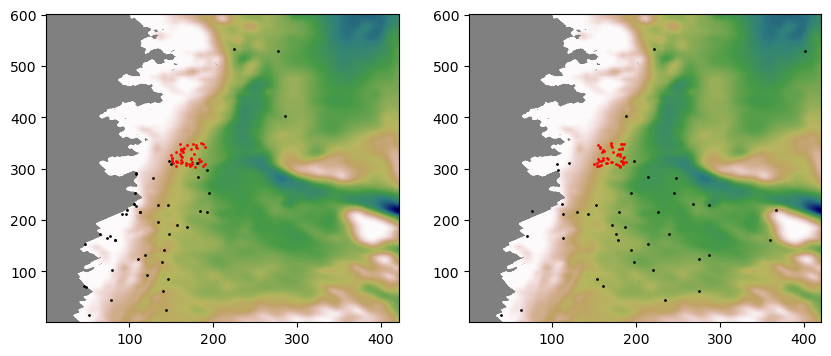

In [22]:
fig, ax = plt.subplots(1,2,figsize=(10, 4))
ax[0].set_facecolor('grey')
cr1=ax[0].pcolormesh(xi,eta,h*mask,shading='gouraud',cmap=plt.cm.gist_earth_r)
ax[0].plot(pxt[0],pyt[0],linestyle='none',marker='o',color='r',markersize=1)
ax[0].plot(pxt[-1],pyt[-1],linestyle='none',marker='o',color='k',markersize=1)

ax[1].set_facecolor('grey')
cr1=ax[1].pcolormesh(xi,eta,h*mask,shading='gouraud',cmap=plt.cm.gist_earth_r)
ax[1].plot(pxnt[0],pyt[0],linestyle='none',marker='o',color='r',markersize=1)
ax[1].plot(pxnt[-1],pyt[-1],linestyle='none',marker='o',color='k',markersize=1)

In [120]:
px[0].data
py[0].data

array([339., 340., 316., 346., 321., 349., 314., 321., 339., 312., 329.,
       324., 318., 333., 316., 316., 313., 347., 350., 349., 310., 304.,
       314., 343., 319., 336., 328., 322., 306., 343., 334., 312., 341.,
       307., 313., 314., 312., 309., 315., 306., 307., 320., 321., 338.,
       326., 348., 305., 333., 312., 310.])

In [94]:


with open("/home/zsm/PY_PART_ROMS-Dauhajre/part_in/test500kpp_in.p", "rb") as f:
    data = pickle.load(f, encoding="latin1")  # 加载数据

In [95]:
px0=data['px']
py0=data['py']
px0.shape

(50,)